<a href="https://colab.research.google.com/github/dainis-boumber/av/blob/master/pretrain_av.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT + Siamese Network for Sentence Vectors
## Part One: Tokenizing
This notebook will tokenize the sentences from the SNLI dataset for use in the next notebook

### You must have the fastai library installed

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ipyexperiments import *
from fastai.text import *
from fastai import *
import json
import html
import re
import pickle
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
from pandas.io.json import json_normalize
import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F
from nltk.tokenize import sent_tokenize
import time
import math
import sys
import data
import joblib

token_files = './data/PAN14/tokens/'
model_files = './data/PAN14/models/'
TRAINDATAPATH = "./data/PAN14/pan14_train_english-essays/"
TESTDATAPATH = "./data/PAN14/pan14_test01_english-essays/"
FNAMES = ['known01','known02','known03','known04','known05', 'unknown']
KCOLS=['known01','known02','known03','known04','known05']
LABELCOL="answer"
UNKOWN="unknown"


In [7]:
BOD = 'x_bod' # beginning-of-doc tag

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def read_dataset(path):
    ds=pd.read_json(path+'/truth.json')
    ds=json_normalize(ds['problems'])
    ds['known01']=None
    ds['known02']=None
    ds['known03']=None
    ds['known04']=None
    ds['known05']=None
    ds['unknown']=None
    ds.set_index('name', drop=True, inplace=True)
    ds=ds[['known01','known02','known03','known04','known05', 'unknown', 'answer']]
    dirs = []
    docs = []

    for i, x in enumerate(os.walk(path)):
        if i:
            for fname in x[2]:
                with open(path+dirs[i-1]+'/'+fname, 'r') as f:
                    text = f.read().strip()
                    doc = BOD.join(sent_tokenize(text))
                    docs.append(doc)
                    ds.loc[dirs[i-1],fname[:-4]]=doc
        else:
            dirs = x[1]

    return ds, docs

def match_unknowns(path):
    ds=pd.read_json(path+'/truth.json')
    ds=json_normalize(ds['problems'])
    ds['known01']=None
    ds['known02']=None
    ds['known03']=None
    ds['known04']=None
    ds['known05']=None
    ds['unknown']=None
    ds.set_index('name', drop=True, inplace=True)
    ds=ds[['known01','known02','known03','known04','known05', 'unknown', 'answer']]
    dirs = []
    docs = []

    ds, _ = read_dataset(path)
            
    grouped=ds.groupby(['unknown'])
    dupes=[]
    for utext, group in grouped:
        if len(group.index) > 1:
            dupes.append(group)


    newrows=pd.DataFrame(columns=['known01','known02','known03','known04','known05', 'unknown'])
    for dupe in dupes:
        dupe.reset_index(drop=True, inplace=True)
        yes=dupe.loc[dupe.answer == "Y"]
        yes.reset_index(drop=True, inplace=True)
        no=dupe.loc[dupe.answer == "N"]
        no.reset_index(drop=True, inplace=True)
        for col in ['known01','known02','known03','known04','known05']:
            if no[col] is not None:
                newrows=newrows.append(pd.DataFrame(data={'known01':yes.known01,'known02':yes.known02,
                                                          'known03':yes.known03, 'known04':yes.known04,
                                                          'known05':yes.known05,'unknown':no[col], 
                                                          'answer':'N'}), sort=False)
    newrows=newrows.dropna(subset=['unknown'])
    df = pd.concat([ds, newrows])
    for col in FNAMES:
        
        docs.extend(df[col].tolist())
    docs=[d for d in docs if d is not None]
    return df, docs

def load_sentence_pairs(df):
   
    s0s = []
    s1s = []
    labels = [1 if label == 'Y' else 0 for label in df[LABELCOL].tolist()]
    
    y=[]
    unknowns = df[UNKOWN].tolist()
    for i, label in enumerate(labels):
        for col in KCOLS:
            knowns = df[col].tolist()

            s0 = knowns[i]
            if s0 is not None:
                s1 = unknowns[i]
                s0s.append(s0)
                s1s.append(s1)
                y.append(label)
    pairs=pd.DataFrame(data={"known":s0s, "unknown":s1s, "label":y})
    return pairs  




In [102]:
df_train, docs = match_unknowns(TRAINDATAPATH)
df_test, _ = read_dataset(TESTDATAPATH)

sentence_pairs_train = load_sentence_pairs(df_train)
sentence_pairs_val = load_sentence_pairs(df_test)
sentence_pairs_test = load_sentence_pairs(df_test)

joblib.dump(sentence_pairs_train, f'{model_files}traindf.pkl')
joblib.dump(sentence_pairs_val, f'{model_files}valdf.pkl')
joblib.dump(sentence_pairs_test, f'{model_files}testdf.pkl')

sentence_pairs_train['label']=0
sentence_pairs_val['label']=0
sentence_pairs_test['label']=0

# Language model data
data_lm = TextLMDataBunch.from_df(model_files, sentence_pairs_train, sentence_pairs_val, sentence_pairs_test,
                                  text_cols=['known', 'unknown'], label_cols=['label'], mark_fields=True, 
                                  min_freq=5, bs=32)
data_lm.save()  

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:21.849
･ CPU:        56      54     2885 MB |
･ GPU:         1       0     2236 MB |


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


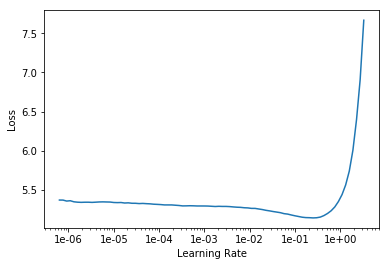

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:15.949
･ CPU:         0       0     2857 MB |
･ GPU:       230     786     2824 MB |


In [118]:
exp1=IPyExperimentsPytorch()
data_lm = TextLMDataBunch.load(model_files)
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=1.0, metrics=[accuracy],
                              callback_fns=ShowGraph)
#learn.metrics=[accuracy]
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,4.463900,4.021371,0.245187
2,4.072473,3.919279,0.251615
3,3.928713,3.886729,0.256254


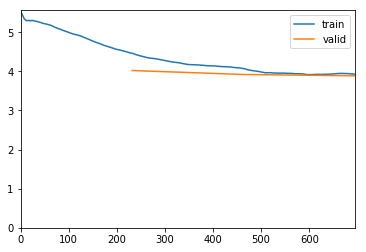

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:01:55.883
･ CPU:         0       1     2817 MB |
･ GPU:      -123     650     2248 MB |


In [104]:
learn.fit_one_cycle(3, max_lr=slice(3e-3,1e-2))

In [105]:
learn.save_encoder('4ft_enc1')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.073
･ CPU:         0       0     2817 MB |
･ GPU:        -3       0     2244 MB |


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


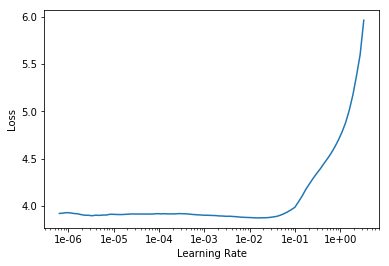

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:18.678
･ CPU:         0       2     2817 MB |
･ GPU:        46     964     2290 MB |


In [106]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,3.842955,3.872503,0.257927
2,3.853006,3.862679,0.259168
3,3.838707,3.856399,0.259673


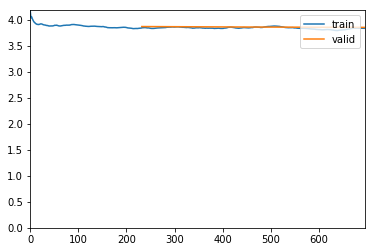

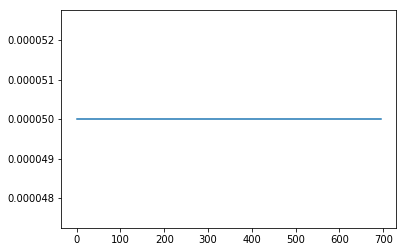

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:02:27.914
･ CPU:         1       1     2817 MB |
･ GPU:       -72    1011     2217 MB |


In [107]:
learn.fit(3, lr=slice(5e-6, 5e-5))
#learn.fit(epochs=1, 2e-2,)
learn.recorder.plot_lr(show_moms=False)


epoch,train_loss,valid_loss,accuracy
1,3.681691,3.786463,0.269662
2,3.482540,3.707646,0.282991
3,3.175068,3.662741,0.294206
4,2.884448,3.605798,0.302571
5,2.656772,3.574438,0.308609
6,2.588931,3.582839,0.308854


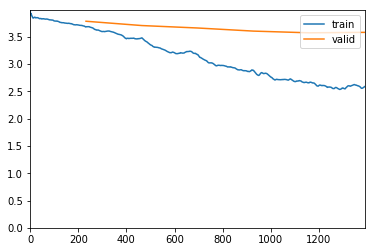

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:04:54.020
･ CPU:         1       1     2817 MB |
･ GPU:        16     908     2234 MB |


In [108]:
learn.fit_one_cycle(6, 3e-3)

In [109]:
learn.save_encoder('4ft_enc2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.074
･ CPU:         0       0     2817 MB |
･ GPU:         0       0     2234 MB |


In [119]:
learn.load_encoder('4ft_enc2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.052
･ CPU:         0       0     2857 MB |
･ GPU:         0       0     2824 MB |


epoch,train_loss,valid_loss,accuracy
1,2.645189,3.635471,0.300485
2,2.607162,3.634758,0.300623


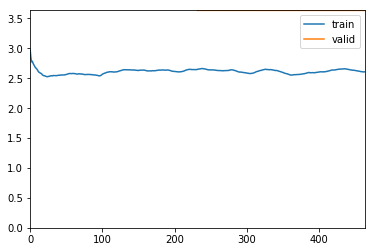

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:01:17.923
･ CPU:         0       1     2857 MB |
･ GPU:      -129     980     2695 MB |


In [120]:
learn.fit_one_cycle(2, 5e-6)

epoch,train_loss,valid_loss,accuracy
1,2.607176,3.634956,0.300657
2,2.595497,3.634369,0.300761
3,2.554508,3.632691,0.300983
4,2.566913,3.632739,0.301118
5,2.578660,3.630370,0.301331
6,2.590091,3.629920,0.301594
7,2.618811,3.628730,0.301672
8,2.607108,3.627614,0.301885
9,2.567099,3.627672,0.301935
10,2.601692,3.627504,0.301885


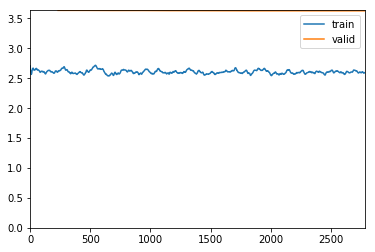

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:07:47.970
･ CPU:         1       1     2857 MB |
･ GPU:       -19    1056     2675 MB |


In [121]:
learn.fit_one_cycle(12, 5e-6)

In [122]:
learn.save_encoder('4ft_enc3')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.069
･ CPU:         0       0     2857 MB |
･ GPU:         0       0     2676 MB |


In [ ]:
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


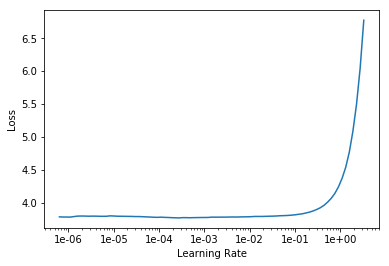

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:13.906
･ CPU:         0       2     2794 MB |
･ GPU:       -84     420     2476 MB |


In [100]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,3.779546,3.750460,0.265106
2,3.729872,3.741394,0.266266


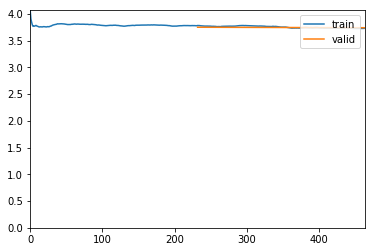

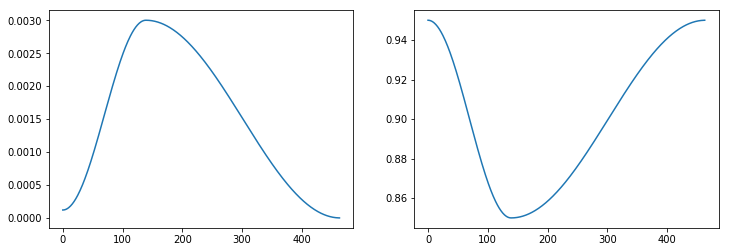

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:01:14.253
･ CPU:         0       1     2794 MB |
･ GPU:      -241     662     2234 MB |


In [101]:

learn.recorder.plot_lr(show_moms=True)
learn.save_encoder('ft_enc3')

In [85]:
learn.load_encoder('ft_enc3')
learn.unfreeze()
learn.save_encoder('ft_enc4')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.127
･ CPU:         0       0     2666 MB |
･ GPU:         0      42     2378 MB |


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


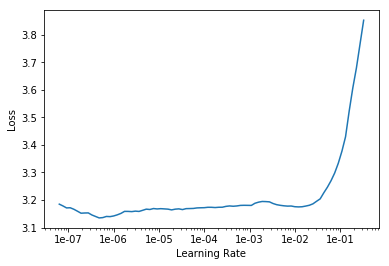

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:18.660
･ CPU:         0       2     2666 MB |
･ GPU:       188     880     2408 MB |


In [83]:

learn.lr_find(start_lr=1e-8, end_lr=1)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


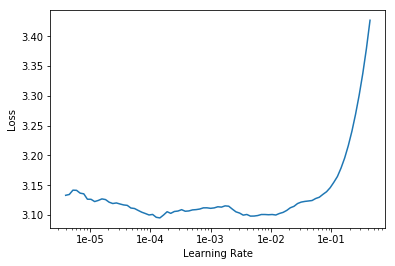

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:14.320
･ CPU:         0       2     2665 MB |
･ GPU:        42     908     2594 MB |


In [57]:
learn.clip=0.1
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))
learn.lr_find(start_lr=1e-6, end_lr=1)
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy
1,3.057049,3.650711,0.292253
2,3.127009,3.650033,0.292316


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:01:16.375
･ CPU:         0       1     2665 MB |
･ GPU:        41     780     2636 MB |


In [86]:
del exp1

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2666 MB |
･ GPU:         0       0     2378 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:21:45 (elapsed wallclock time)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:       0       0 MB (  0.00%)
GPU:     -88       0 MB ( -0.00%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2666 47421  64352 MB   4.14% 
GPU:  2378  5739   8117 MB  29.30% 


